In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from tracker import tracker

%autosave 15

Autosaving every 15 seconds


In [2]:
# Read in the Saved ObjPoints and ImgPoints
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb"))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Import Images
images = glob.glob('./test_images/test*.jpg')

In [3]:
'''================================================
        Function Definitions
==================================================='''
'''----------------------------
        Color Threshold
-------------------------------'''
def color_threshold(image, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    s_binary = np.zeros_like(s_channel)
    sthresh_2 = sthresh
    s_binary[(s_channel >= sthresh_2[0]) & (s_channel <= sthresh_2[1]) ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1]) ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

'''----------------------------
        ABS Sobel
-------------------------------'''
def abs_sobel_thresh(img, orient="x", thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient is 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient is 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)

    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

'''----------------------------
        Mag Threshold
-------------------------------'''
def mag_thresh(image, sobel_kernel = 3, mag_thresh = (0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    binary_output = np.zeros_like(gradmag)

    binary_output[(gradmag >= mag_thresh[0])& (gradmag <= mag_thresh[1])] = 1
    return binary_output


'''--------------------------------------
        Directional Gradient Threshold
----------------------------------------'''
def dir_threshold(img, sobel_kernel=7, thresh=(0, 0.09)):
    # GrayScale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Gradient in X and Y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # ABS of X and Y gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Direction of Gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)

    # Binary Mask
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return binary_output

'''----------------------------
        Window Mask
-------------------------------'''
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level+1)*height):int(img_ref.shape[0] - level*height),
            max(0, int(center-width)): min(int(center + width),  img_ref.shape[1])] = 1
    return output

'''----------------------------
        Show Images
-------------------------------'''
def show(img, img2=None, img3=None, title=None, title1=None, title2=None, title3=None):

    # 1 Image
    if (img2 is None):
        plt.imshow(img, cmap='gray')

    # 2 Images
    elif img3 is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.imshow(img, cmap='gray')
        ax2.imshow(img2, cmap='gray')

    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
        ax1.imshow(img, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        ax3.imshow(img3, cmap='gray')
        
    if title1 is not None:
        ax1.set_title(title1)
        
    if title2 is not None:
        ax2.set_title(title2)

    if title3 is not None:
        ax3.set_title(title3)
        
    if(title is not None):
        plt.savefig(title, bbox_inches='tight')

    plt.show()

    

### Import Image

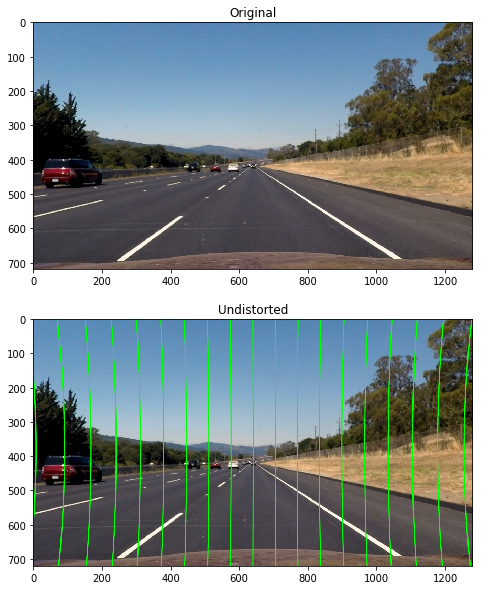

In [4]:
# Import
original = cv2.imread("./test_images/straight_lines2.jpg")
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

img_grid = original.copy()
nx_lines = 20
ny_lines = 10

x1 = 0
y1 = 0

x2 = 0
y2 = 720

x_spacing = int(original.shape[1] / nx_lines)

for line in range(nx_lines):
    
    x1 += x_spacing
    x2 += x_spacing
    cv2.line(img_grid, (x1, y1), (x2, y2), (0, 255, 0), 2)
    

# Undistort
img_grid = cv2.undistort(img_grid, mtx, dist, None, mtx)
img = cv2.undistort(original, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.set_title('Original')
ax1.imshow(img)

ax2.set_title('Undistorted')
ax2.imshow(img_grid)

plt.savefig("Undistorted.png", bbox_inches='tight')


### Evaluate Thresholds

In [5]:
import ipywidgets as widgets
from IPython.display import display

import helper_functions
from tracker import tracker

# Read in the Saved ObjPoints and ImgPoints
dist_pickle = pickle.load( open( "calibration_pickle.p", "rb"))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

525


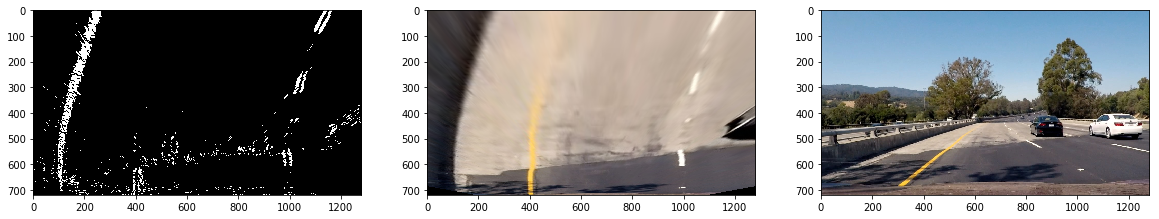

In [131]:
images = glob.glob('test_images/*.jpg')

# Perspective Matricies
img = cv2.imread('./test_images/test1.jpg')
M, Minv = helper_functions.get_transform(img)

warped = helper_functions.warp_image(img, M)

helper_functions.show(img, warped)

def update_binary(smin=3, smax=255, 
                  bmin=0, bmax=209, 
                  dmin=0.1, dmax=0.9, 
                  mmin=0, mmax=300,
                  d_kernal=13,
                  m_kernal=5,
                  picture=5):
    
    img = cv2.imread(images[picture])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    warped = helper_functions.warp_image(img, M)

    color_binary = helper_functions.color_threshold(warped, (smin, smax), (bmin, bmax))

    dir_binary = helper_functions.dir_threshold(warped, d_kernal, (dmin, dmax))

    mag_binary = helper_functions.mag_threshold(warped, m_kernal, (mmin, mmax))

    output = np.zeros_like(dir_binary)
    output[(color_binary == 1) & (dir_binary ==1) & (mag_binary == 0)] = 1


    helper_functions.show(output, warped, img)


w_color = widgets.interactive(update_binary)
display(w_color)

### Perspective Transform

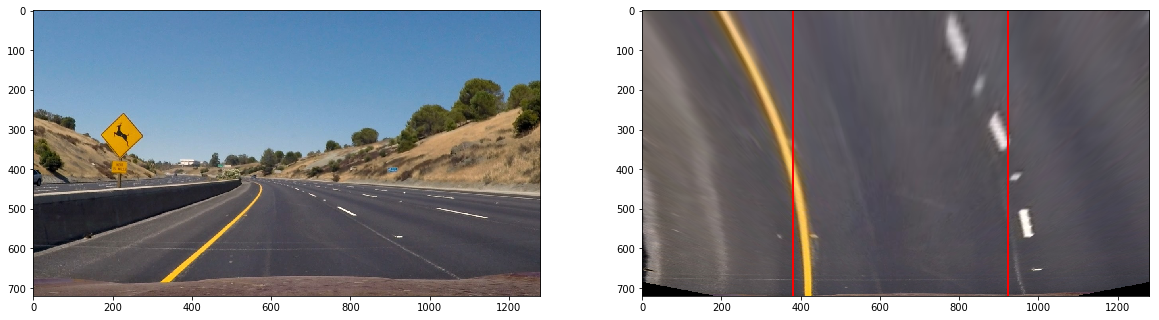

In [7]:
img = cv2.imread(images[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

M, Minv = helper_functions.get_transform(img)

warped = helper_functions.warp_image(img, M)

x1=x2=381
x3 = x4 = 921

y1 = y3 = 0
y2 = y4 = 720

red = [255, 0, 0]

cv2.line(warped, (x1, y1), (x2, y2), red, thickness=3)
cv2.line(warped, (x3, y3), (x4, y4), red, thickness=3)

show(img, warped, title="WarpCalibration")

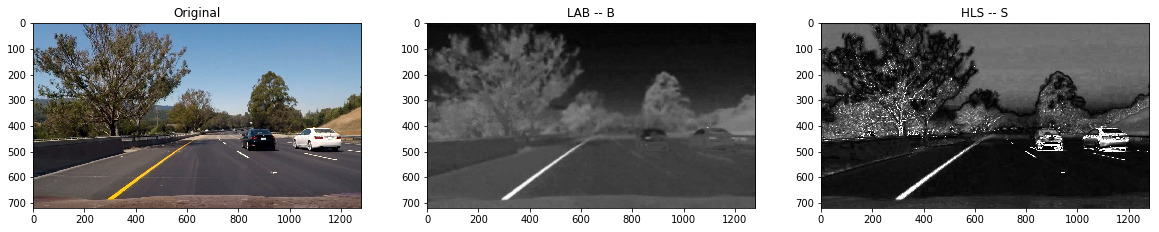

In [8]:
img = cv2.imread(images[5])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

b = lab[:, :, 2]
s = hls[:, :, 2]

show(img, b, s, "ColorChannels", "Original", "LAB -- B", "HLS -- S")

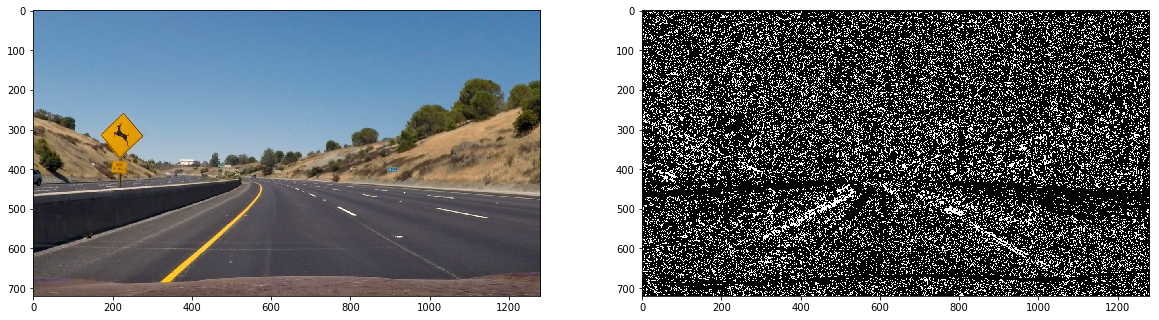

In [64]:
import helper_functions

img = cv2.imread(images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = helper_functions.warp_image(img, M)

grad = helper_functions.dir_threshold(img, 13, (0.9, 1.2))
mag = helper_functions.mag_threshold(warped, 5, (50, 100))
show(img, grad)

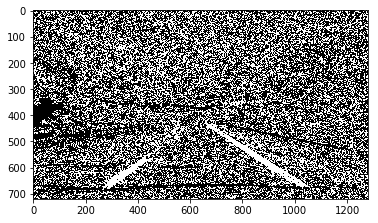

In [69]:
mmin = 50
mmax = 300
kernal = 7

def update_warped(dmin=0.5, dmax=1.0, kernal=9):
    
    img = cv2.imread(images[1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mag = helper_functions.dir_threshold(img, kernal, (dmin, dmax))
    show(mag)
    
mag_widget = widgets.interactive(update_warped)
display(mag_widget)

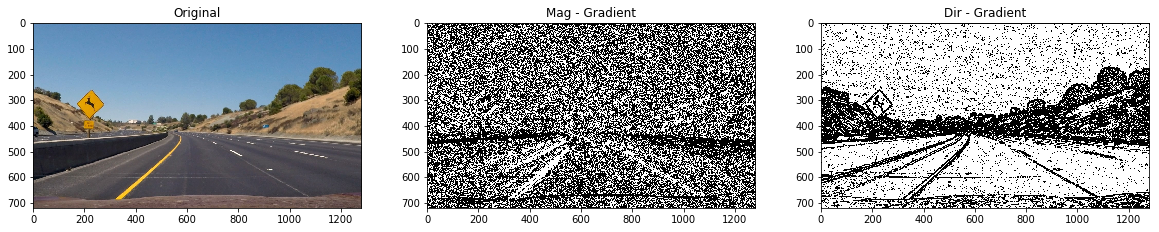

In [71]:
mmin = 19
mmax = 300
m_kernal = 5

dmin = 0.7
dmax = 1.3
d_kernal = 15

img = cv2.imread(images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mag = helper_functions.mag_threshold(img, m_kernal, (mmin, mmax))
dir = helper_functions.dir_threshold(img, d_kernal, (dmin, dmax))

show(img, dir, mag, "GradientThresholds", "Original", "Mag - Gradient", "Dir - Gradient")

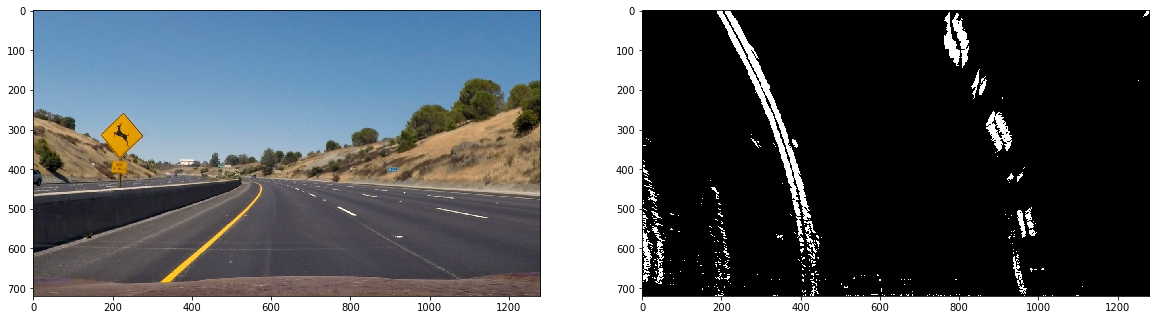

In [75]:
img = cv2.imread(images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = helper_functions.warp_image(img, M)

binary = helper_functions.create_binary(warped)
show(img, binary, title="BinaryOutput")

525


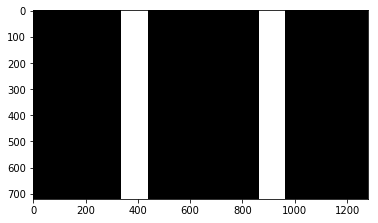

In [79]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Process Image
warped = helper_functions.warp_image(img, M)
binary = helper_functions.create_binary(warped)

# Dimensions
img_height = binary.shape[0]
img_width = binary.shape[1]

# Histogram
midpoint = (img_width // 2)
histogram = np.sum(binary, axis=0)
left_lane = np.argmax(histogram[:midpoint])
right_lane = np.argmax(histogram[midpoint:]) + midpoint
spread = right_lane - left_lane

print(spread)

# Template
window_width = 50
s_template = np.zeros((img_height, img_width))
s_template[:, left_lane - window_width:left_lane + window_width] = 1
s_template[:, right_lane - window_width:right_lane + window_width] = 1

show(s_template, title="StraightLineTemplate")

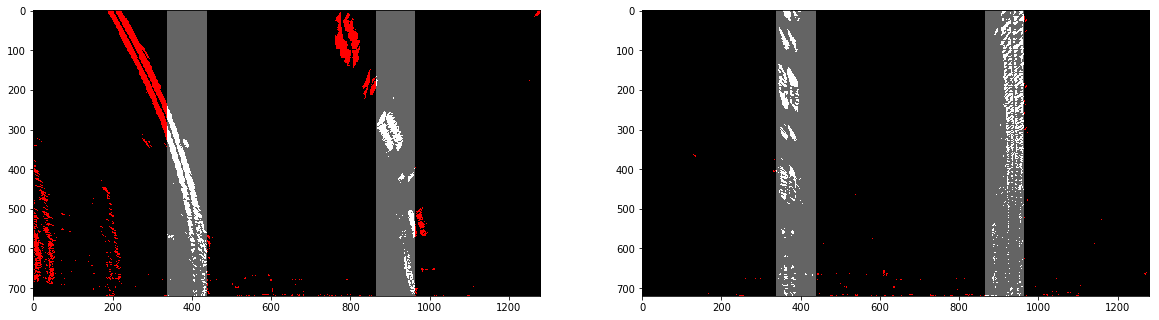

In [91]:
img = cv2.imread(images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = helper_functions.warp_image(img, M)

binary = helper_functions.create_binary(warped)

test = np.copy(img)
test[:, :, :] = 0
test[(s_template == 1)] = [100, 100, 100]
test[(s_template == 1) & (binary == 1)] = [255, 255, 255]  
test[(s_template == 0) & (binary == 1)] = [255, 0, 0]

img = cv2.imread(images[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = helper_functions.warp_image(img, M)

binary = helper_functions.create_binary(warped)

test2 = np.copy(img)
test2[:, :, :] = 0
test2[(s_template ==1)] = [100, 100, 100]
test2[(s_template == 1) & (binary == 1)] = [255, 255, 255]  
test2[(s_template == 0) & (binary == 1)] = [255, 0, 0]


show(test, test2, title="Straight_vs_template")



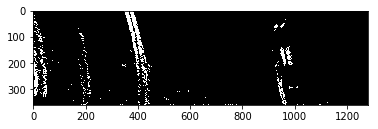

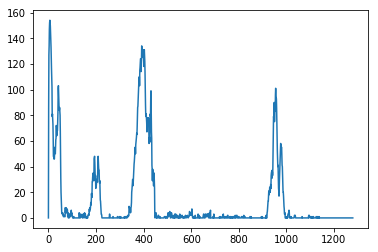

In [126]:
img = cv2.imread(images[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = helper_functions.warp_image(img, M)

binary = helper_functions.create_binary(warped)

img_height = binary.shape[0]

midpoint = binary.shape[1] //2



img_layer = binary[(img_height ) // 2: , : ]
histogram = np.sum(img_layer, axis=0)
show(img_layer)

hist = plt.plot(histogram)
plt.savefig('histogram.jpg')


In [127]:
left_lane_base = np.argmax(histogram[300:500]) + 300
right_lane_base = np.argmax(histogram[800: 1100]) + 800

window_width = 25


392 955
